In [1]:
# This script simulates random walk (heat diffusion) on RNAseq data. Users need to determine a source and a target node. The result is visualization of the diffusion of the heat that reaches the target cell.
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import distance

# dir = "/Users/ozgun/Data/Josh/"
dir = "/home/ozgunbabur/Data/Josh/"

data_file = dir + "normalized_mat.tsv"

pca_pre_file = dir + "pca_coords_8.tsv"
pca_file = dir + "pca_8.tsv"

umap_coords = dir + "umap_coords.tsv"
# umap_file = dir + "umap_coords_transposed.tsv"
umap_file = dir + "umap.tsv"
dist_euc_file = dir + "dist_euclidean.tsv"
dist_cos_file = dir + "dist_cosine.tsv"
dist_cos_asis_file = dir + "dist_cosine_asis.tsv"
dist_um_file = dir + "dist_umap.tsv"



In [26]:
# Calculates the similarity matrix based on distances. First parameter is a DataFrame.
def get_similarity_matrix_df(data_frame:pd.DataFrame, sigmasq:float):
    return get_similarity_matrix(data_frame.to_numpy(), sigmasq)

# Calculates the similarity matrix based on distances
def get_similarity_matrix(m:np.array, sigmasq:float):
    nRow, nCol = m.shape
    sim_mat = np.full((nCol, nCol), 0.0)

    for i in range(0, nCol):
        for j in range(i, nCol):

            # Squared Euclidean distance
            dif = m[:, i] - m[:, j]
            d = np.dot(dif, dif)

            # Cosine distance
            # d = distance.cosine(m[:, i], m[:, j])

            # Use Gaussian similarity kernel to convert distance into similarity
            s = np.exp(-d / sigmasq)

            # Save the similarity on the result matrix, which is symmetric
            sim_mat[i][j] = s
            sim_mat[j][i] = s

    return sim_mat

# Generates transition probabilities from the similarities
def get_probability_matrix(sim_mat):
    sums = np.sum(sim_mat, axis=1)
    p_mat = (sim_mat.T / sums).T
    return p_mat

# Generates the flows between pairs of cells using transition probabilities
# and the current heat distribution
def get_flow_matrix(p_matrix, heat):
    return (heat * p_matrix.T).T

# Next round of heat distribution is determined by the incoming fow to each cell
def get_next_heat(flow):
    return np.sum(flow, axis=0)

# Generates flow matrices for k rounds of heat distribution.
# Also returns how much heat has arrived at targets on each round (sink_list)
def generate_flow_matrices(p_matrix, source_indicator, target_indicator, k:int):
    # Heat flow at each step
    flow_list = []

    # Heat that arrives to the target(s) at each step. That heat is absorbed by target(s),
    # hence we say the heat sinks.
    sink_list = []

    # Heat of cells
    heat = np.zeros(len(source_indicator))

    # Source cells are hot (1), all other cells are cold (0).
    heat[source_indicator] = 1

    # The differential sinking heat in last step. If the parameter k (total number of steps) is given as -1, then the simulation goes on until this differential becomes negative.
    diff = 1

    while (k < 0 < diff) or (k > len(flow_list)):
        # Get the next flows using the probability matrix and current heat distribution
        flow = get_flow_matrix(p_matrix, heat)
        flow_list.append(flow)

        # Calculate the new heat distribution based on the new flows
        heat = get_next_heat(flow)

        # Record how much of this flow reached target(s), and sank
        sink_list.append(np.sum(heat[target_indicator]))

        # Check the trend in sinking heat
        if len(sink_list) > 1:
            diff = sink_list[-1] - sink_list[-2]

    return flow_list, sink_list

# For the heat that has arrived at iteration k, this function generates the list of heat distribution at each step. It also returns a cumulative flow matrix that focuses on the heat that arrived to target.
def generate_weights(flow_matrices, target_indicator, arrive_index:int):
    if arrive_index == -1:
        arrive_index = len(flow_matrices) - 1

    # Part of the flow that arrives to target
    sub_flow = np.zeros(flow_matrices[0].shape)

    # Number of cells
    cell_size = len(target_indicator)

    # The weights matrix where each row is for one turn of heat distribution
    # Weight: The heat that will arrive to the target(s)
    weights_mat = np.zeros((arrive_index + 2, cell_size))

    # The ratios array indicates how much of the in-flow will arrive to the target(s)
    ratios = np.zeros(cell_size)

    # The last step in-flow to the targets will arrive to targets in full, so their ratios are 1
    ratios[target_indicator] = 1

    # The array of in-flows to each cell
    inflow_sums = np.sum(flow_matrices[arrive_index], axis = 0)

    # Weights at the last step is in-flows to the targets and zero for everything else
    weights = inflow_sums * ratios

    # Put this weights array to the last row of weights matrix
    weights_mat[arrive_index + 1, :] = weights

    # Now we will calculate the rest of the weight arrays by going backwards in time
    index = arrive_index

    while index >= 0:
        # Calculate prior weights
        weights = np.matmul(flow_matrices[index], ratios.T)

        # Identify the components of flows at this step that arrived to the target(s) at arrive_index
        # Add those flows to the cumulative matrix
        sub_flow += flow_matrices[index] * ratios

        # Find out-flows for each cell
        outflow_sums = np.sum(flow_matrices[index], axis = 1)

        # Calculate the new ratios of emitted heat that arrive at the target(s)
        ratios = weights / outflow_sums

        # Targets have zero outflows. That generates nans in the previous division. We replace them with zeros here.
        ratios[np.isnan(ratios)] = 0

        # Save new weights
        weights_mat[index, :] = weights

        # Go one back in time
        index = index - 1

    return weights_mat, sub_flow

# This is the cumulative version of the above function. It is for the heat that arrived at iteration k or earlier.
def generate_cumulative_weights(flow_matrices, target_indicator, max_arrive_index):

    # If arrive_index is negative, use the last flow matrix
    if max_arrive_index < 0:
        max_arrive_index = len(flow_matrices) - 1

    # This is the double cumulative sub-flow matrix
    sub_flow_cum = np.zeros(flow_matrices[0].shape)

    # We will generate weight arrays for the heat that arrives at arrive index, then for the heat that arrives at arrive_index-1 and so on.
    index = max_arrive_index
    m_list = []
    while index >= 0:
        # Get the weight arrays and sub-flow matrix for the heat that arrives to target(s) at step "index"
        w, f = generate_weights(flow_matrices, target_indicator, index)

        # Save the weight matrix
        m_list.append(w)

        # Add the cumulative sub-flows to the double-cumulative sub-flow matrix
        sub_flow_cum += f

        # Go back in arrival time
        index -= 1

    # Initialize cumulative weights
    weights = np.zeros(m_list[0].shape)

    # Integrate the weight matrices. After integration, weights are the heat on these cells that will arrive at the target(s) at step arrive_index or earlier
    for i in range(len(weights)):
        for j in range(min(max_arrive_index - i + 2, max_arrive_index + 1)):
            weights[i] += m_list[j][i]

    return weights, sub_flow_cum

# This function is used by the plot animator to update the colors.
def update_plot(i, data, scat):
    scat.set_array(data[i])
    return scat

# The plot will use the most intense color for heat value 1. This method determines the total heat on the plot at any time so that the flow can be visualized clearly. Optimal value depends on the specific dataset.
def rescale_weights(weights, total_heat):
    maximum = np.sum(weights[0])
    factor = total_heat / maximum
    return weights * factor

# Gets the pairs of cells sorted to the detected sub-flow
def get_sorted_pairs(sub_flow):
    flow_map = {}
    for i in range(len(sub_flow)):
        for j in range(len(sub_flow[i])):
            flow_map[(i, j)] = sub_flow[i, j]

    return sorted(flow_map.items(), key=lambda x:x[1], reverse=True)

# Takes a sub-flow and a partial trajectory, completes the trajectory so that
# it starts with src_ind and ends with trg_ind
def build_trajectory(sub_flow, traj, src_ind, trg_ind):

    # Check if the partial trajectory is valid
    if src_ind in traj and traj[0] != src_ind:
        raise Exception("Partial trajectory has the src_index but it not at the start")
    if trg_ind in traj and traj[-1] != trg_ind:
        raise Exception("Partial trajectory has the trg_index but it not at the end")

    # The trajectory will grow with other cells that are not on the trajectory yet
    candidates = [x for x in range(len(sub_flow)) if x not in traj]

    # Grow the trajectory backward using the highest flow coming to the first cell in the current trajectory.
    # Stop when source cell is reached
    while traj[0] != src_ind:
        left = traj[0]
        vec = sub_flow[:, left]

        max_ind = -1
        max_val = -1
        for i in candidates:
            if i != left and vec[i] > max_val:
                max_val = vec[i]
                max_ind = i

        traj.insert(0, max_ind)
        candidates.remove(max_ind)

    # Grow the trajectory forward using the highest flow from the last cell on the trajectory.
    # Stop when target cell is reached
    while traj[-1] != trg_ind:
        right = traj[-1]
        vec = sub_flow[right, :]

        max_ind = -1
        max_val = -1
        for i in candidates:
            if i != right and vec[i] > max_val:
                max_val = vec[i]
                max_ind = i

        traj.append(max_ind)
        candidates.remove(max_ind)

    return traj

# Checks if a given pair of cells is already an edge in one of the trajectories
def already_part_of_a_trajectory(s, t, trajs):
    for traj in trajs:
        if s in traj:
            ind = traj.index(s)
            if ind != len(traj) - 1 and traj[ind + 1] == t:
                return True
    return False

# This method finds the ratios of the inflow each cell received actually arrives at the destination.
# The last parameter max_arrival_index must be the same max_arrival_index that was used to prepare the sub_flow_matrix.
# Otherwise, the computation would be incorrect.
def get_ultimate_arrival_ratios(flow_matrices:np.array, subflow_matrix:np.array, max_arrival_index):
    # A negative max_arrival_index means it is the last flow matrix
    if max_arrival_index < 0:
        max_arrival_index = len(flow_matrices) - 1

    # Calculate total inflows for each cell during the simulation
    tot_inflows = np.zeros(len(subflow_matrix))
    for i in range(max_arrival_index + 1):
        tot_inflows += np.sum(flow_matrices[i], axis=0)

    # Calculate total inflows that arrive to targets
    sub_inflows = np.sum(subflow_matrix, axis=0)

    # Get their ratios
    ratios = sub_inflows / tot_inflows

    return ratios

# Gets the ultimate ratios of those cells on a given trajectory
def get_ratios_over_trajectory(ratios:np.array, traj):
    return ratios[traj]

# Pseudotime is calculated based on euclidean distances
def get_pseudotime_of_trajectory(mat:np.array, traj):
    time = np.zeros(len(traj))
    for i in range(1, len(traj)):
        c1 = traj[i-1]
        c2 = traj[i]
        d = distance.euclidean(mat[:, c1], mat[:, c2])
        time[i] = time[i-1] + d
    return time


Probabilities set
flows length = 50


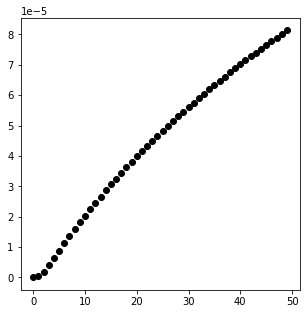

In [99]:
# Load the data matrix
# dataF = pd.read_table(umap_file, index_col=0)
dataF = pd.read_table(pca_file, index_col=0)

# Get the cell names and size
cols = dataF.columns.values.tolist()
size = len(cols)

# Determine source and target indices

# src_ind = cols.index('tumor_GGGCATCAGTGTACCT-1') #45 tumor
src_ind = cols.index('midpoint_AACACGTTCGGCGCTA-1') #892 luminal
trg_ind = cols.index('midpoint_TGGTTCCTCACTATTC-1') #1 basal
# trg_ind = cols.index('midpoint_AACACGTTCGGCGCTA-1') #892 luminal

# Generate the boolean arrays that mark source and target cells
source_indicator = np.full(size, False)
source_indicator[src_ind] = True
target_indicator = np.full(size, False)
target_indicator[trg_ind] = True

# Generate the similarity matrix based on distances on the data
sim = get_similarity_matrix_df(dataF, sigmasq=30)

# Generate the transition probabilities based on the distances
p_mat = get_probability_matrix(sim)

# Target cells absorb the heat. They don't transmit any of it. They are sinks in the system.
p_mat[target_indicator,:] = 0

print("Probabilities set")

# Decide how many steps the simulation will be
simulation_length = 50

# Simulate the heat distribution
flows, sinks = generate_flow_matrices(p_mat, source_indicator, target_indicator, simulation_length)

print("flows length = " + str(len(flows)))

# Plot how the heat sinks at the target(s) at each step
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(np.array(range(len(sinks))), sinks, color = 'k')
plt.show()

In [100]:
# Using the flows, get the distribution of the heat (at each step) that reaches the target at the end of the simulation or earlier. Weight: Heat that reaches the target during the simulation.
unscaled_weights, sub_flow = generate_cumulative_weights(flows, target_indicator, -1)

# Adjust the scale of weights for visualization
weights = rescale_weights(unscaled_weights, 500)
print("weights = \n" + str(weights))

/tmp/ipykernel_1902500/2840945317.py:125: RuntimeWarning: invalid value encountered in true_divide
  ratios = weights / outflow_sums


weights = 
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.29077703e-02 1.23681250e-04 6.12371547e-09 ... 4.58532481e-36
  9.48827461e-34 6.27652687e-30]
 [6.50149014e-02 6.23261904e-03 8.27945294e-06 ... 1.27779062e-21
  5.99216468e-20 5.01765623e-18]
 ...
 [1.34541100e-02 6.17029377e-02 2.34446194e-08 ... 1.21815330e-22
  1.67218242e-20 1.87789796e-18]
 [5.18543705e-03 3.21746046e-02 2.69320571e-11 ... 3.49513635e-37
  7.17508457e-34 8.32503222e-29]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [101]:

# Generate 5 distinct trajectories that has the pairs with maximal sub-flow
pairs = get_sorted_pairs(sub_flow)
trajs = []
i = 0
while len(trajs) < 4:
    s = pairs[i][0][0]
    t = pairs[i][0][1]

    if not already_part_of_a_trajectory(s, t, trajs):
        traj = [s, t]
        traj = build_trajectory(sub_flow, traj, src_ind, trg_ind)
        trajs.append(traj)
    i += 1

# Calculate ranks based on maximum weights
maxes = np.max(weights, axis=0)
ranks = maxes.argsort().argsort()

# Read UMAP coordinates of the cells
table = pd.read_table(umap_file, index_col=0)
mat = table.to_numpy()

# Convert cell trajectories to line paths to plot
paths = []
for i in range(len(trajs)):
    path = mat[:, trajs[i]]
    paths.append(path)

In [102]:

# Order dots (cells) so that darker ones painted later
colors = np.zeros((len(weights), len(weights[0])))
pos = np.zeros(mat.shape)
for i in range(len(ranks)):
    pos[:, ranks[i]] = mat[:, i]
    for j in range(len(weights)):
        colors[j][ranks[i]] = max(weights[j][i], 0.13)

[0.53315434 0.87988521 0.35351666 ... 0.67315663 0.62323073 0.44153195]


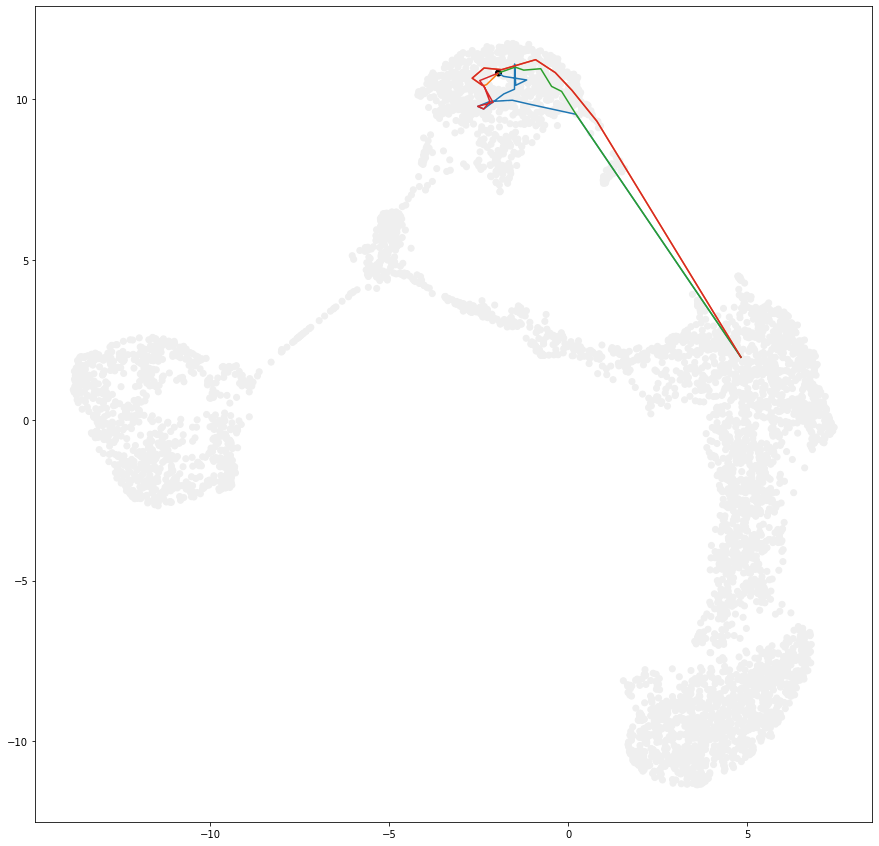

In [103]:


# We need some initial colors. These will not be visualized. The minimum value should be 0 and the maximum value should be 1. The plot will assign colors based on that scale.
initial_colors = np.random.rand(len(colors[0]))
initial_colors[0] = 0
initial_colors[1] = 1

# Generate the scatter plot of cells
fig = plt.figure(figsize=(15, 15))
scat = plt.scatter(pos[0], pos[1], c = initial_colors, cmap='Greys', alpha=1)

# Draw the trajectories
for i in range(len(paths)):
    plt.plot(paths[i][0], paths[i][1])

# Animate the simulation on the plot by updating cell colors
ani = animation.FuncAnimation(fig, update_plot, frames=len(colors), fargs=(colors, scat))

# Save the animation as a GIF
ani.save('heat-flow-animation.gif', writer='pillow')

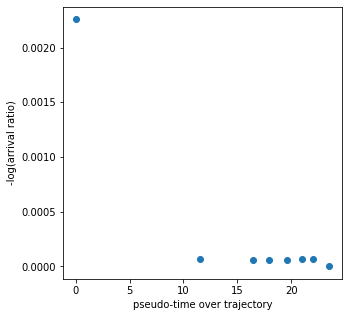

[ 0.         11.55545479 16.48212316 17.94145484 19.62705427 20.97631914
 22.04374495 23.5198208 ]


In [106]:
# The rest is some experimental code

trj = trajs[2]
#ultimate_ratios = get_ultimate_arrival_ratios(flows, sub_flow, -1)
#rats_over_trj = get_ratios_over_trajectory(ultimate_ratios, trj)

sub_outflows = np.sum(sub_flow, axis=1)
flow_over_trj = get_ratios_over_trajectory(sub_outflows, trj)

mat = dataF.to_numpy()
fig = plt.figure(figsize=(5, 5))
plt.scatter(get_pseudotime_of_trajectory(mat, trj), flow_over_trj)
plt.xlabel("pseudo-time over trajectory")
plt.ylabel("-log(arrival ratio)")
plt.show()

print(get_pseudotime_of_trajectory(mat, trj))

